In [ ]:
from gensim.models import KeyedVectors

# Charger le modèle Word2Vec pour l'anglais
import nltk
import gensim
from nltk.corpus import abc
nltk.download('punkt')
import gensim.downloader as api
corpus = api.load('text8')
model_en = gensim.models.Word2Vec(corpus, workers=4)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
from nltk.tokenize import word_tokenize
# Charger le modèle Word2Vec pour le français
nltk.download('punkt_tab')
# Charger un fichier texte contenant des phrases en français
corpus_file = "fr_corpus.txt"

# Lire les phrases et les tokeniser
with open(corpus_file, "r", encoding="utf-8") as f:
    sentences = [word_tokenize(line.lower()) for line in f]

print("Exemple de phrase tokenisée :", sentences[1])
model_fr =gensim.models.Word2Vec(sentences, vector_size=100, window=3, min_count=2, workers=4, sg=0)
#from gensim.models import KeyedVectors
#from huggingface_hub import hf_hub_download
#model_fr = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_frwiki_20180420_100d", filename="frwiki_20180420_100d.txt"))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Exemple de phrase tokenisée : []


In [ ]:
# Jeu de données d'exemple
sentences_fr = [
    "Bonjour, comment allez-vous ?",
    "Il fait beau aujourd'hui.",
    "Je vais à Paris demain."
]

sentences_en = [
    "Hello, how are you?",
    "The weather is nice today.",
    "I am going to Paris tomorrow."
]


In [ ]:
# Jeu de données d'exemple
sentences_fr = [
    "Bonjour, comment allez-vous aujourd'hui en cette belle journée ensoleillée où tout semble aller pour le mieux ?",
    "Il fait beau aujourd'hui avec un ciel dégagé, une légère brise rafraîchissante, et un soleil radieux qui illumine tout autour.",
    "Je vais à Paris demain pour visiter la tour Eiffel, flâner le long de la Seine, et découvrir quelques-uns des musées les plus célèbres du monde."
]

sentences_en = [
    "Hello, how are you doing today in this wonderful moment when everything seems peaceful and full of promise?",
    "The weather is nice today with clear blue skies, a gentle breeze brushing against your skin, and the perfect temperature for a walk.",
    "I am going to Paris tomorrow to explore its historic landmarks, enjoy the vibrant culture, and indulge in some authentic French cuisine."
]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import numpy as np
!pip install nltk
import nltk

nltk.download('punkt_tab')
# Prétraitement des phrases
def preprocess_sentences(sentences, model):
    tokenized = [word_tokenize(sentence.lower()) for sentence in sentences]
    vectors = [
        [model.wv[word] for word in sentence if word in model.wv]  # Changed line
        for sentence in tokenized
    ]
    return vectors

# Prétraiter les phrases en français et en anglais
vectors_fr = preprocess_sentences(sentences_fr, model_fr)
vectors_en = preprocess_sentences(sentences_en, model_en)

# Padding pour uniformiser la longueur des séquences
max_len = max(max(len(v) for v in vectors_fr), max(len(v) for v in vectors_en))
vectors_fr = pad_sequences(vectors_fr, maxlen=max_len, dtype="float32", padding="post")
vectors_en = pad_sequences(vectors_en, maxlen=max_len, dtype="float32", padding="post")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense

# Dimensions des embeddings
embedding_dim = 100

# Encodeur
encoder_inputs = Input(shape=(max_len, embedding_dim))
encoder_rnn = SimpleRNN(128, return_state=True)
encoder_outputs, state_h = encoder_rnn(encoder_inputs)

# Décodeur
decoder_inputs = Input(shape=(max_len, embedding_dim))
decoder_rnn = SimpleRNN(128, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_rnn(decoder_inputs, initial_state=state_h)
decoder_dense = Dense(embedding_dim, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Modèle complet
model = Model([encoder_inputs, decoder_inputs], [decoder_outputs, state_h])
model.compile(optimizer="adam", loss="mse")

# Résumé du modèle
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 25, 100)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 25, 100)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ [(None, 128), (None,   │         29,312 │ input_layer_1[0][0]    │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ [(None, 25, 128),      │         29,312 │ input_layer_2[0][0],   │
│                           │ (None, 128)]           │                │ simple_rnn[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 25, 100)        │         12,900 │ simple_rnn_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 71,524 (279.39 KB)

 Trainable params: 71,524 (279.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Préparer les données pour le décodeur
decoder_input_data = np.roll(vectors_en, shift=1, axis=1)  # Décaler les séquences d'entrée du décodeur
decoder_input_data[:, 0, :] = 0  # Ajouter un token de début

# Entraînement
model.fit(
    [vectors_fr, decoder_input_data],
    vectors_en,
    batch_size=32,
    epochs=50
)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.7251
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.6380
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 1.5594
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.4886
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.4241
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.3652
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.3111
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.2614
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1.2153
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.1725
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.1324
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.0948
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.0593
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.0259
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.9943
Epoch 16/50
1/1 ━━━━━━━━━━━━━

In [ ]:
def translate_sentence(sentence, model_fr, model, max_len):
    # Prétraiter la phrase
    sentence_vector = preprocess_sentences([sentence], model_fr)
    sentence_vector = pad_sequences(sentence_vector, maxlen=max_len, dtype="float32", padding="post")

    # Initialiser le décodeur
    decoder_input = np.zeros((1, max_len, embedding_dim))
    decoded_sentence = []

    # Générer les mots un par un
    state_h = None
    for i in range(max_len):
        # Prédire le prochain mot
        decoder_output, state_h = model.predict([sentence_vector, decoder_input], verbose=0)
        next_word_vector = decoder_output[0, i, :]
        decoded_sentence.append(next_word_vector)

        # Mettre à jour l'entrée du décodeur
        decoder_input[:, i, :] = next_word_vector

    return decoded_sentence

# Exemple
translated_vector = translate_sentence("Je vais à Paris demain pour visiter la tour Eiffel, flâner le long de la Seine, et découvrir quelques-uns des musées les plus célèbres du monde.", model_fr, model, max_len)


In [ ]:
def vector_to_words(vector_sequence, word2vec_model):
    """
    Convert a sequence of word vectors into words using a Word2Vec model.

    Args:
        vector_sequence (list of numpy arrays): The sequence of word embeddings.
        word2vec_model (gensim.models.KeyedVectors): Pretrained Word2Vec model.

    Returns:
        list: The sequence of words corresponding to the vectors.
    """
    words = []
    for vector in vector_sequence:
        # Skip zero padding vectors
        if not vector.any():
            continue
        # Find the most similar word
        word = word2vec_model.wv.similar_by_vector(vector, topn=1)[0][0]
        words.append(word)
    return words

# Convert the translated vectors to words
translated_words = vector_to_words(translated_vector, model_en)

# Join the words into a sentence
translated_sentence = " ".join(translated_words)
print("Translated Sentence:", translated_sentence)


Translated Sentence: i advance to the job this final full moment what clear just this this again france what the full full moment everyone you this this


# Traduction Automatique avec Mécanisme d'Attention
Implémenter un modèle de traduction automatique séquentielle en utilisant le mécanisme d’attention pour améliorer les performances.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate

# Paramètres
embedding_dim = 100
latent_dim = 128
max_len = 25  # Longueur maximale des séquences

# Encodeur
encoder_inputs = Input(shape=(max_len, embedding_dim), name="encoder_inputs")
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Décodeur
decoder_inputs = Input(shape=(max_len, embedding_dim), name="decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Attention
attention = Dot(axes=[2, 2], name="attention")([decoder_outputs, encoder_outputs])
attention = Activation('softmax', name="attention_softmax")(attention)
context = Dot(axes=[2, 1], name="context")([attention, encoder_outputs])

# Concatenation avec les sorties du décodeur
decoder_combined_context = Concatenate(axis=-1, name="concat_context")([context, decoder_outputs])

# Couche dense pour prédiction
decoder_dense = Dense(embedding_dim, activation="linear", name="decoder_dense")
decoder_final_outputs = decoder_dense(decoder_combined_context)

# Modèle complet
model = Model([encoder_inputs, decoder_inputs], decoder_final_outputs)
model.compile(optimizer="adam", loss="mse")

# Résumé du modèle
model.summary()

# Exemple d'entraînement
decoder_input_data = np.roll(vectors_en, shift=1, axis=1)
decoder_input_data[:, 0, :] = 0

model.fit(
    [vectors_fr, decoder_input_data],
    vectors_en,
    batch_size=32,
    epochs=50
)

# Traduction avec Attention
def translate_with_attention(sentence, model_fr, model, max_len):
    sentence_vector = preprocess_sentences([sentence], model_fr)
    sentence_vector = pad_sequences(sentence_vector, maxlen=max_len, dtype="float32", padding="post")

    decoder_input = np.zeros((1, max_len, embedding_dim))
    decoded_sentence = []

    state_h, state_c = None, None
    for i in range(max_len):
        outputs = model.predict([sentence_vector, decoder_input], verbose=0)
        next_word_vector = outputs[0, i, :]
        decoded_sentence.append(next_word_vector)
        decoder_input[:, i, :] = next_word_vector

    return decoded_sentence

# Exemple de test
translated_vector = translate_with_attention("Je vais à Paris demain pour visiter la tour Eiffel, flâner le long de la Seine, et découvrir quelques-uns des musées les plus célèbres du monde.", model_fr, model, max_len)
translated_words = vector_to_words(translated_vector, model_en)
translated_sentence = " ".join(translated_words)
print("Translated Sentence:", translated_sentence)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 25, 100)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 25, 100)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 25, 128),      │        117,248 │ encoder_inputs[0][0]   │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 25, 128),      │        117,248 │ decoder_inputs[0][0],  │
│                           │ (None, 128), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 128)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Dot)           │ (None, 25, 25)         │              0 │ decoder_lstm[0][0],    │
│                           │                        │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_softmax         │ (None, 25, 25)         │              0 │ attention[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context (Dot)             │ (None, 25, 128)        │              0 │ attention_softmax[0][… │
│                           │                        │                │ encoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_context            │ (None, 25, 256)        │              0 │ context[0][0],         │
│ (Concatenate)             │                        │                │ decoder_lstm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 25, 100)        │         25,700 │ concat_context[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 260,196 (1016.39 KB)

 Trainable params: 260,196 (1016.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2617
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.2163
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1801
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1495
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1233
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1012
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0827
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.0667
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0517
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0372
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0228
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0086
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9943
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9801
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9660
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

# Exercice 4 :Création d'un Modèle d'Analyse de Sentiment avec LSTM, attention et Word2Vec
L'analyse de sentiment est un problème classique en traitement automatique du langage naturel (TALN) où le but est de déterminer si un texte exprime une opinion positive ou négative. Dans ce TP, vous utiliserez un corpus annoté contenant des avis (par exemple, des avis de films) pour entraîner un modèle basé sur une architecture LSTM.

Les étapes principales incluent :

1. Prétraitement des données textuelles.
2. Utilisation de Word2Vec pour générer des vecteurs d'embedding pour les mots du corpus.
3. Construction d'une architecture LSTM/attention pour capturer les dépendances séquentielles dans les textes.
4. Entraînement et évaluation du modèle sur des données annotées.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import gensim.downloader as api

In [ ]:
word2vec=model_en
word_vectors = word2vec.wv
vocab_size = len(word_vectors)

In [ ]:
# Étape 1 : Charger et entraîner le modèle Word2Vec
print("Chargement et entraînement de Word2Vec...")
corpus = api.load('text8')  # Charger un corpus de texte pré-entraîné
word2vec = gensim.models.Word2Vec(corpus, vector_size=100, workers=4)  # Taille de l'embedding = 100
word_vectors = word2vec.wv  # Récupérer les vecteurs de mots
vocab_size = len(word_vectors)  # Taille du vocabulaire
print(f"Word2Vec entraîné avec un vocabulaire de {vocab_size} mots.")


In [ ]:
# Étape 2 : Prétraitement des données IMDB
print("Prétraitement des données IMDB...")
max_features = 10000  # Limite des mots les plus fréquents
maxlen = 500  # Longueur des séquences

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Ajouter des zéros pour aligner toutes les séquences à maxlen
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


Prétraitement des données IMDB...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Étape 3 : Créer une matrice d'embedding basée sur Word2Vec
print("Création de la matrice d'embedding Word2Vec...")
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in imdb.get_word_index().items():
    if index < max_features:
        try:
            embedding_vector = word_vectors[word]
            embedding_matrix[index] = embedding_vector
        except KeyError:
            continue  # Si le mot n'existe pas dans Word2Vec, on le laisse à zéro

Création de la matrice d'embedding Word2Vec...
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
# Étape 4 : Construire le modèle LSTM
from tensorflow.keras.layers import Flatten,Input, Embedding, LSTM, Dense, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, Permute, Reshape, Multiply, RepeatVector, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np

# Fonction pour le mécanisme d'attention
def attention_layer(inputs):
    """
    Calcule une pondération attentionnelle des sorties de la LSTM.
    """
    # Calcul des scores d'attention
    attention_scores = Dense(1, activation='tanh')(inputs)
    attention_scores = Flatten()(attention_scores)
    attention_weights = Activation('softmax')(attention_scores)

    # Pondérer les sorties avec les scores d'attention
    attention_weights = RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    weighted_output = Multiply()([inputs, attention_weights])

    # Somme pondérée des sorties
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(weighted_output)
    return context_vector

# Paramètres du modèle
max_features = 20000  # Taille du vocabulaire
embedding_dim = 100   # Dimension des vecteurs d'embedding
maxlen = 500          # Longueur maximale des séquences

# Entrée
inputs = Input(shape=(maxlen,))
embedding = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen)(inputs)

# LSTM bidirectionnelle
lstm_output = Bidirectional(LSTM(128, return_sequences=True))(embedding)

# Mécanisme d'attention
attention_output = attention_layer(lstm_output)

# Classification
dense = Dense(64, activation='relu')(attention_output)
dropout = Dropout(0.3)(dense)
outputs = Dense(1, activation='sigmoid')(dropout)

# Construction du modèle
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 100)       │      2,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 500, 256)       │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 500, 1)         │            257 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 500)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 500)            │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 256, 500)       │              0 │ activation[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 500, 256)       │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 500, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         16,448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,251,266 (8.59 MB)

 Trainable params: 2,251,266 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Étape 5 : Entraîner le modèle
print("Entraînement du modèle...")
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2, verbose=2)

Entraînement du modèle...
Epoch 1/5
157/157 - 20s - 130ms/step - accuracy: 0.6830 - loss: 0.5538 - val_accuracy: 0.8660 - val_loss: 0.3306
Epoch 2/5
157/157 - 13s - 84ms/step - accuracy: 0.8978 - loss: 0.2617 - val_accuracy: 0.8866 - val_loss: 0.2784
Epoch 3/5
157/157 - 21s - 135ms/step - accuracy: 0.9347 - loss: 0.1826 - val_accuracy: 0.8836 - val_loss: 0.2854
Epoch 4/5
157/157 - 20s - 128ms/step - accuracy: 0.9516 - loss: 0.1409 - val_accuracy: 0.8872 - val_loss: 0.2976
Epoch 5/5
157/157 - 21s - 131ms/step - accuracy: 0.9647 - loss: 0.1043 - val_accuracy: 0.8838 - val_loss: 0.3353


In [ ]:
# Étape 6 : Évaluer le modèle
print("Évaluation sur les données de test...")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Précision sur les données de test : {accuracy:.2f}")

Évaluation sur les données de test...
Précision sur les données de test : 0.87


In [ ]:
# Étape 7 : Tester le modèle avec un exemple
print("Prédiction sur un exemple...")
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(sequence):
    return " ".join([reverse_word_index.get(i - 3, "?") for i in sequence])

sample_index = 1
sample_review = x_test[sample_index]
predicted_sentiment = model.predict(sample_review.reshape(1, -1))[0][0]
# Call the decode_review function to get the decoded review string
decoded_review = decode_review(sample_review)
decoded_review = ' '.join(decoded_review.replace('?', '').split()) # remove the unknown words i.e ?
print(f"Avis : {decoded_review}") #Print the decoded review
print(f"Sentiment prédit : {'Positif' if predicted_sentiment > 0.5 else 'Négatif'} (score : {predicted_sentiment:.2f})")

Prédiction sur un exemple...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Avis : this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere with sexual tension and psychological it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual a

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


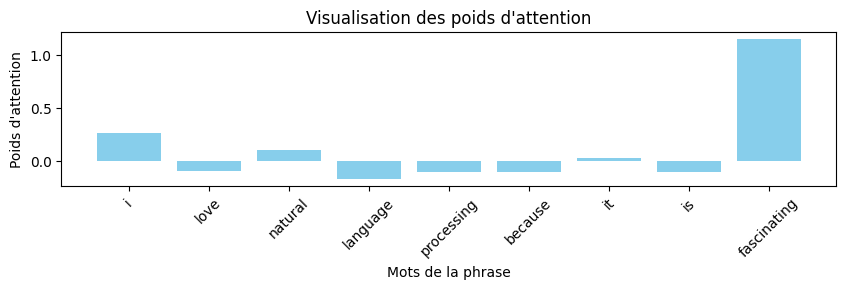

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Exemple de phrase
sentence = "I love natural language processing because it is fascinating."

# Tokenisation de la phrase
tokenizer = Tokenizer()
tokenizer.fit_on_texts([sentence])  # Crée le vocabulaire à partir de la phrase
sequence = tokenizer.texts_to_sequences([sentence])  # Convertit en séquence d'indices
word_index = tokenizer.word_index  # Dictionnaire mot -> indice
padded_sequence = pad_sequences(sequence, maxlen=maxlen)  # Padding pour correspondre à la longueur maxlen

# Extraire les poids d'attention
attention_model = Model(inputs=model.input, outputs=model.get_layer("lambda").output)
attention_weights = attention_model.predict(padded_sequence)

# Préparer les données pour la visualisation
attention_weights = attention_weights.reshape(-1)[:len(sequence[0])] # Retirer les dimensions inutiles
#attention_weights = np.squeeze(attention_weights)
words = list(tokenizer.word_index.keys())  # Liste des mots

# Fonction pour normaliser les poids d'attention
def normalize_attention(weights):
    return weights / np.sum(weights)

normalized_weights = normalize_attention(attention_weights)

# Visualisation des poids d'attention
plt.figure(figsize=(10, 2))
#plt.bar(words, normalized_weights, color="skyblue")
plt.bar(words[:len(normalized_weights)], normalized_weights, color="skyblue")
plt.xlabel("Mots de la phrase")
plt.ylabel("Poids d'attention")
plt.title("Visualisation des poids d'attention")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Génération de Descriptions d'Images avec VGG16 et LSTM

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from PIL import Image
import zipfile
import requests

# Téléchargement du dataset Flickr8k
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
annotations_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Téléchargement des fichiers
for url in [dataset_url, annotations_url]:
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        print(f"Téléchargement de {filename}...")
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)

# Extraction des fichiers
with zipfile.ZipFile("Flickr8k_Dataset.zip", "r") as zip_ref:
    zip_ref.extractall("Flickr8k_Dataset")

with zipfile.ZipFile("Flickr8k_text.zip", "r") as zip_ref:
    zip_ref.extractall("Flickr8k_text")

print("Dataset téléchargé et extrait avec succès.")


Dataset téléchargé et extrait avec succès.


In [ ]:
# Charger VGG16 en tant qu'encodeur
vgg16 = VGG16(weights='imagenet', include_top=False)
encoder_model = Model(inputs=vgg16.input, outputs=vgg16.layers[-1].output)

# Fonction pour extraire les caractéristiques des images
def preprocess_image(image_path):
    image = Image.open(image_path).resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def extract_features(directory):
    features = {}
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = preprocess_image(img_path)
        feature = encoder_model.predict(img)
        features[img_name] = feature
    return features

# Extraction des caractéristiques pour toutes les images
image_dir = "Flickr8k_Dataset/Flicker8k_Dataset"
features = extract_features(image_dir)
np.save("image_features.npy", features)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

In [ ]:
# Charger les descriptions
def load_descriptions(file_path):
    with open(file_path, "r") as file:
        text = file.read()
    descriptions = {}
    for line in text.strip().split("\n"):
        tokens = line.split("\t")
        img_id, caption = tokens[0], tokens[1]
        img_id = img_id.split("#")[0]  # Garder uniquement l'ID de l'image
        descriptions.setdefault(img_id, []).append(caption)
    return descriptions

descriptions = load_descriptions("Flickr8k_text/Flickr8k.token.txt")

# Prétraitement des descriptions
def preprocess_descriptions(descriptions):
    tokenizer = Tokenizer()
    all_captions = ["startseq " + caption + " endseq" for captions in descriptions.values() for caption in captions]
    tokenizer.fit_on_texts(all_captions)
    sequences = tokenizer.texts_to_sequences(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(seq) for seq in sequences)
    return tokenizer, vocab_size, max_length

tokenizer, vocab_size, max_length = preprocess_descriptions(descriptions)


In [49]:
# Entrées de l'encodeur
image_input = Input(shape=(7, 7, 512))
image_flatten = Dense(256, activation='relu')(image_input)
# Reshape image_flatten to match the shape of dropout, calculate the first dimension
# to ensure the total number of elements remain unchanged after reshape
image_flatten = Reshape((image_flatten.shape[1] * image_flatten.shape[2], 256))(image_flatten)
# Reshape to (49, 256)



# Entrées du décodeur
text_input = Input(shape=(max_length,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
lstm = LSTM(256, return_sequences=True)(embedding)
dropout = Dropout(0.3)(lstm)

# Combinaison encodeur-décodeur
# Assuming max_length == 39 and based on the new image_flatten shape (49, 256), you will
# need to either truncate or pad the image_flatten tensor or change the shape of the LSTM
# to match the image_flatten. Here we pad the lstm sequence to max_length 49
decoder = Add()([tf.keras.layers.ZeroPadding1D(padding=(0, image_flatten.shape[1]-max_length))(dropout), image_flatten])  # Now shapes should be compatible
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'zero_padding1d' (of type ZeroPadding1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [1]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size=32):
    # Create a list of all image IDs
    all_img_ids = list(descriptions.keys())

    while True:
        # Shuffle the image IDs for each epoch
        np.random.shuffle(all_img_ids)

        for i in range(0, len(all_img_ids), batch_size):
            batch_img_ids = all_img_ids[i:i + batch_size]

            # Initialize empty lists for batch data
            batch_images = []
            batch_sequences = []
            batch_targets = []

            for img_id in batch_img_ids:
                for caption in descriptions[img_id]:
                    input_img = features[img_id + '.jpg']  # Add '.jpg' extension to image ID
                    input_img = input_img.reshape((1, 7, 7, 512))

                    input_seq = tokenizer.texts_to_sequences(["startseq " + caption + " endseq"])[0]

                    for j in range(1, len(input_seq)):
                        x_seq = pad_sequences([input_seq[:j]], maxlen=max_length)[0]
                        y_word = to_categorical([input_seq[j]], num_classes=vocab_size)[0]

                        # Append data to batch lists
                        batch_images.append(input_img[0])
                        batch_sequences.append(x_seq)
                        batch_targets.append(y_word)

            # Convert batch lists to NumPy arrays
            batch_images = np.array(batch_images)
            batch_sequences = np.array(batch_sequences)
            batch_targets = np.array(batch_targets)

            yield [batch_images, batch_sequences], batch_targets



# ... (vector_to_words function remains the same) ...

# Get image IDs for training and validation (e.g., 80% for training)
img_ids = list(descriptions.keys())
train_size = int(len(img_ids) * 0.8)
train_img_ids = img_ids[:train_size]
val_img_ids = img_ids[train_size:]

# Create data generators for training and validation
train_generator = data_generator({k: descriptions[k] for k in train_img_ids}, features, tokenizer, max_length, vocab_size)
val_generator = data_generator({k: descriptions[k] for k in val_img_ids}, features, tokenizer, max_length, vocab_size)

# Calculate steps per epoch
steps_per_epoch = sum(len(descriptions[img_id]) for img_id in train_img_ids) // 32  # Assuming batch_size = 32
validation_steps = sum(len(descriptions[img_id]) for img_id in val_img_ids) // 32

# Train the model
model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps
)

NameError: name 'descriptions' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


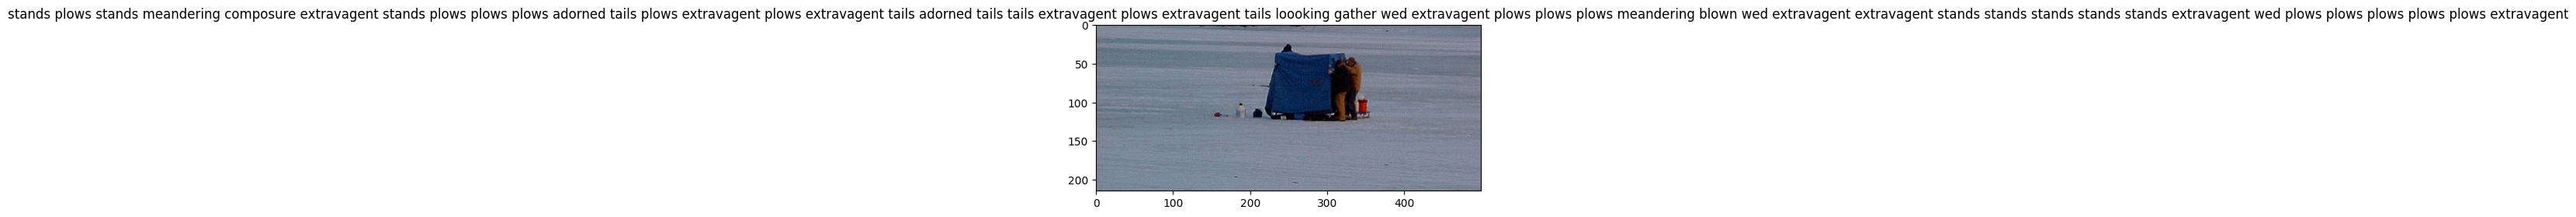

Caption générée : stands plows stands meandering composure extravagent stands plows plows plows adorned tails plows extravagent plows extravagent tails adorned tails tails extravagent plows extravagent tails loooking gather wed extravagent plows plows plows meandering blown wed extravagent extravagent stands stands stands stands stands extravagent wed plows plows plows plows plows extravagent


In [57]:


# Fonction pour transformer les vecteurs en mots
def vector_to_words(vector_sequence, tokenizer):
    """
    Convertit une séquence de vecteurs de mots en mots en utilisant le tokenizer.

    Args:
        vector_sequence (list of numpy arrays): La séquence de vecteurs de mots.
        tokenizer (keras.preprocessing.text.Tokenizer): Le tokenizer utilisé pour la tokenisation.

    Returns:
        str: La séquence de mots correspondant aux vecteurs.
    """
    index_to_word = {index: word for word, index in tokenizer.word_index.items()}
    words = []
    for vector in vector_sequence:
        # Obtenir l'index du mot avec la probabilité la plus élevée
        index = np.argmax(vector)

        # Vérifier si l'index est valide
        if index in index_to_word:
            word = index_to_word[index]
            words.append(word)
    return " ".join(words)



# Exemple de génération de descriptions
example_img_path = "Flickr8k_Dataset/Flicker8k_Dataset/103205630_682ca7285b.jpg"  # Verify the path to your image
example_img = preprocess_image(example_img_path)

# Extract features from the example image using the encoder model
example_img_features = encoder_model.predict(example_img)

# Reshape the features to match the model's input shape (7, 7, 512)
example_img_features = example_img_features.reshape((1, 7, 7, 512))

# Create a dummy text input sequence (you'll need to implement your own logic here)
# For example, you could use a start sequence token and pad with zeros
dummy_text_input = np.zeros((1, max_length))
dummy_text_input[0, 0] = tokenizer.word_index['startseq']  # Assuming 'startseq' is in your vocabulary

# Now, predict using both the image features and the dummy text input
predicted_caption_vectors = model.predict([example_img_features, dummy_text_input])

# Convertir les vecteurs en mots
predicted_caption = vector_to_words(predicted_caption_vectors[0], tokenizer)


# Afficher l'image
plt.imshow(Image.open(example_img_path))
plt.title(predicted_caption)
plt.show()

print("Caption générée :", predicted_caption)